# AMG+ for 1D Helmholtz: 4/2 Repetitive Coarsening, 3-level
* Constant $k$. $k h$ designed so that wavelength evenly divides the domain.
* Discretization: 5-point (4th order).
* Kaczmarz relaxation.
* Fixed-domain problem; repetitive, so we sample windows from a test vector.
* Using ideal TVs.
* Interpolation LS fitting is weighted by $\|A x^{(k)}\|^{-1}$, where $k$ runs over test functions, and the norm is local (over 3 aggregates when fitting interpolation in an aggregate). This forces the interpolation row sums to be $1$, as the constant null-space vector has infinite LS weight. Thus $A^c$ is exactly singular and $b^c$ is exactly compatible with it at the coarse level in the cycle.

In [50]:
%run /Users/olivne/helmholtz/src/helmholtz/startup.ipy

In [51]:
# Fixed seed for reproducible results.
np.random.seed(0)

# Domain size.
n = 96 # 192
domain_size = n   # With meshsize h = 1.
# Scaled wave number. Fit so lam_min = 0 (integer # periods in domain).
discretization = "5-point" # "3-point"
#kh = 0
kh = helmholtz.analysis.ideal.find_singular_kh(discretization, n)[0]
#kh = 0.5

repetitive = True

# Test vectors.
ideal_tv = False    # Use eigenvectors or not.
# Number of test vectors.  
num_examples = 4

# Set # sweeps manually here.
num_sweeps_on_vectors = 20 # None
threshold = 0.1

# Boottstrapping parameters.
interpolation_method = "ls" # "weighted_ls" #"ls"
fit_scheme = "plain"
weighted = False #True
neighborhood = "extended" #"aggregate" # "extended"
num_test_examples = 5
leeway_factor = 1.2

# Mock cycle/two-level cycle nu value list.
nu_values = np.arange(1, 12)

_LOGGER.info("kh {}".format(kh))

INFO     kh 0.5233853805513011


## Level 0->1 Coarsening

In [52]:
# Create fine-level matrix.
a = hm.linalg.helmholtz_1d_discrete_operator(kh, discretization, n).tocsr()

# Use default = Kacmzarz relaxation for kh != 0.
level = hm.setup.hierarchy.create_finest_level(a,  relaxer=hm.solve.relax.GsRelaxer(a) if kh == 0 else None)

# Initialize hierarchy to 1-level.
finest = 0
multilevel = hm.setup.hierarchy.multilevel.Multilevel.create(level)

# 'location' is an array of variable locations at all levels. Used only for interpolation neighbor determination.
# Finest-level variable ocations are assumed to be [0..n-1], i.e. a domain of size n with meshsize h = 1.
level.location = np.arange(n)

# TV and TV residual history.
x_log = []
r_log = []

# Save null-space vectors so we dan orthogonalize error vectors to them.
num_eigenvectors = 10
z, lam = hm.analysis.ideal.ideal_tv(level.a, num_eigenvectors)
ind = (np.abs(lam[:num_eigenvectors]) < 1e-6)
z = z[:, ind]
z = hm.linalg.gram_schmidt(z)

### Relaxation


INFO     Kaczmarz
INFO     Iter     |r|                         |x|         RER
INFO     0     1.310e+00                    4.468e-01    2.925
INFO     1     7.259e-01 (0.555) [0.555]    3.426e-01    2.123 (0.725)
INFO     2     4.208e-01 (0.581) [0.568]    2.928e-01    1.447 (0.681)
INFO     3     2.668e-01 (0.635) [0.590]    2.670e-01    1.011 (0.698)
INFO     4     1.851e-01 (0.695) [0.615]    2.515e-01    0.746 (0.739)
INFO     5     1.397e-01 (0.755) [0.641]    2.409e-01    0.589 (0.789)
INFO     6     1.138e-01 (0.815) [0.668]    2.330e-01    0.496 (0.843)
INFO     7     9.689e-02 (0.852) [0.691]    2.267e-01    0.434 (0.876)
INFO     8     8.543e-02 (0.882) [0.713]    2.214e-01    0.392 (0.904)
INFO     9     7.703e-02 (0.902) [0.731]    2.169e-01    0.360 (0.921)
INFO     10    7.057e-02 (0.916) [0.748]    2.129e-01    0.336 (0.934)
INFO     11    6.545e-02 (0.927) [0.763]    2.093e-01    0.317 (0.943)
INFO     12    6.127e-02 (0.936) [0.776]    2.060e-01    0.301 (0.951)
INFO 

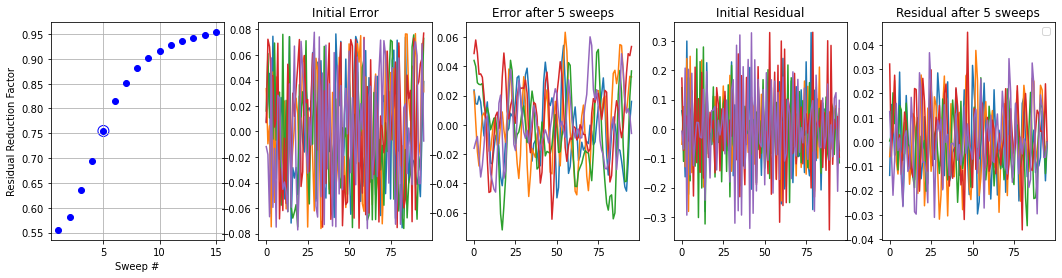

In [53]:
method_info = hm.solve.smoothing.check_relax_cycle_shrinkage(
    multilevel, num_levels=1, leeway_factor=leeway_factor, slow_conv_factor=0.95, num_examples=5)
num_sweeps = method_info["Kaczmarz"][1]

### Coarsening: Fixed (4/2)
Measure local two-level rates on a domain of size $m=6$ aggregates.

In [122]:
nu = num_sweeps_on_vectors if num_sweeps_on_vectors is not None else num_sweeps
aggregate_size = 4
num_components = 2
nu_coarsest = -1
m = 8

all_conv, r, p, q = helmholtz.analysis.stats.compare_coarsening(level, nu, 
                       domain_size,
                       aggregate_size, num_components,
                       ideal_tv=ideal_tv,
                       num_examples=num_examples,
                       nu_values=nu_values,
                       nu_coarsest=nu_coarsest,
                       interpolation_method=interpolation_method,
                       fit_scheme=fit_scheme,
                       weighted=weighted,
                       neighborhood=neighborhood,
                       repetitive=repetitive,
                       m=m)

styler = all_conv.style.set_caption("Convergence Factors").format(precision=4)
display_html(styler._repr_html_(), raw=True)

INFO     Generating 4 TVs with 20 sweeps
INFO     RER 0.217


,Fill-in,Symmetry,1,2,3,4,5,6,7,8,9,10,11
Mock,nan,nan,0.5351,0.1487,0.1298,0.1064,0.0941,0.0750,0.0684,0.0651,0.0604,0.0431,0.0461
P^T A P caliber 2,1.1429,0.0000,0.4517,0.3230,0.4357,0.4099,0.4087,0.3974,0.3860,0.3550,0.3668,0.3582,0.3455
P^T A P caliber 3,1.2987,0.0000,0.5481,0.2712,0.2191,0.2307,0.1931,0.1810,0.1777,0.1825,0.1465,0.1686,0.1702
P^T A P caliber 4,1.7662,0.0000,0.3923,0.2157,0.1403,0.1119,0.1134,0.0842,0.0652,0.0506,0.0456,0.0399,0.0370
R A P caliber 4,1.1429,0.0033,0.9223,0.3388,0.1906,0.1352,0.0855,0.0729,0.0488,0.0373,0.0553,0.0541,0.0494
Q A P caliber 4,1.1429,0.0002,0.9982,0.3272,0.1528,0.1068,0.0849,0.0633,0.0558,0.0555,0.0590,0.0549,0.0178


In [126]:
# Using GMRES as as a coarse-level solver seems to be a robust choice vs. m (domain size).
m = 4
nu_coarsest = -1
ml = hm.repetitive.locality.create_two_level_hierarchy_from_matrix(
    level.a.tocsr(), level.location, r, p, p.T, aggregate_size, num_components, m=m)
two_level_conv = hm.repetitive.locality.two_level_conv_factor(
    ml, 8, nu_coarsest=nu_coarsest, print_frequency=1, debug=False, num_sweeps=8)

INFO     Iter   |r|        Factor   RER    Factor   |e|   
INFO     0      8.930e+00           2.305           3.873
INFO     1      2.784e-01  (0.031)  1.878  (0.815)  0.148
INFO     2      2.072e-02  (0.074)  1.703  (0.907)  0.012
INFO     3      1.356e-03  (0.065)  2.048  (1.203)  0.001
INFO     4      7.226e-05  (0.053)  2.600  (1.269)  0.000
INFO     5      3.025e-06  (0.042)  3.196  (1.229)  0.000
INFO     6      1.029e-07  (0.034)  2.997  (0.938)  0.000
INFO     7      3.858e-09  (0.037)  1.766  (0.589)  0.000
INFO     8      2.451e-10  (0.064)  1.787  (1.012)  0.000


## Symmetrizing $R A P$ into $Q A P$

### Slowest Component, RER reduction
All measurements (RER, plot of errors) are performed after removing the null components after each cycle. Cycles are $(0, \nu)$, so the error is measured after relaxations.

#### Two-level Cycle with exact coarse level solve

Restriction r
INFO     Iter   |r|        Factor   RER    Factor   |e|   
INFO     0      2.087e+01           2.468           8.455
INFO     1      5.983e+00  (0.287)  1.050  (0.426)  5.697
INFO     2      8.429e+00  (1.409)  1.873  (1.784)  4.500
INFO     3      1.263e+01  (1.498)  1.769  (0.945)  7.139
INFO     4      2.080e+01  (1.647)  1.878  (1.061)  11.075
INFO     5      3.167e+01  (1.523)  1.780  (0.948)  17.793
INFO     6      5.128e+01  (1.619)  1.865  (1.047)  27.503
INFO     7      7.959e+01  (1.552)  1.797  (0.964)  44.297
INFO     8      1.262e+02  (1.586)  1.845  (1.027)  68.401
INFO     9      2.001e+02  (1.585)  1.817  (0.985)  110.114
INFO     10     3.106e+02  (1.552)  1.823  (1.003)  170.378
INFO     11     5.027e+02  (1.618)  1.839  (1.009)  273.336
INFO     12     7.654e+02  (1.523)  1.801  (0.979)  424.951
INFO     13     1.260e+03  (1.646)  1.859  (1.032)  677.732
INFO     14     1.891e+03  (1.501)  1.783  (0.959)  1060.873
INFO     15     3.147e+03  (1.664)  1.8

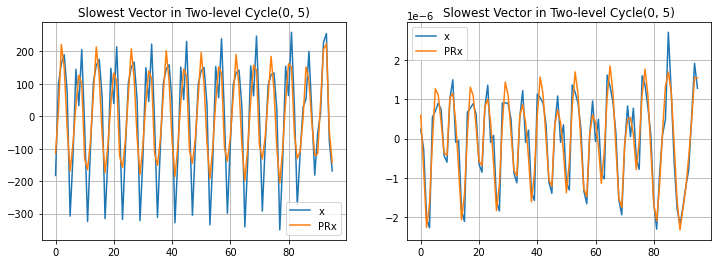

In [55]:
helmholtz.analysis.stats.run_r_vs_q(level, z, r, p, q, aggregate_size, num_components, 5, -1)

#### Two-level Cycle with many relaxations at coarse level

Restriction r
INFO     Iter   |r|        Factor   RER    Factor   |e|   
INFO     0      2.087e+01           2.468           8.455
INFO     1      3.162e+00  (0.152)  0.626  (0.254)  5.053
INFO     2      3.338e-01  (0.106)  0.587  (0.937)  0.569
INFO     3      4.668e-02  (0.140)  0.618  (1.054)  0.075
INFO     4      8.568e-03  (0.184)  0.575  (0.930)  0.015
INFO     5      1.541e-03  (0.180)  0.591  (1.028)  0.003
INFO     6      3.006e-04  (0.195)  0.588  (0.995)  0.001
INFO     7      5.824e-05  (0.194)  0.594  (1.010)  0.000
INFO     8      1.144e-05  (0.196)  0.591  (0.994)  0.000
INFO     9      2.270e-06  (0.199)  0.595  (1.008)  0.000
INFO     10     4.658e-07  (0.205)  0.607  (1.020)  0.000
INFO     11     9.392e-08  (0.202)  0.594  (0.978)  0.000
INFO     12     1.852e-08  (0.197)  0.584  (0.984)  0.000
INFO     13     3.695e-09  (0.199)  0.588  (1.007)  0.000
INFO     14     7.382e-10  (0.200)  0.589  (1.001)  0.000
INFO     15     1.463e-10  (0.198)  0.584  (0.993)  0.000

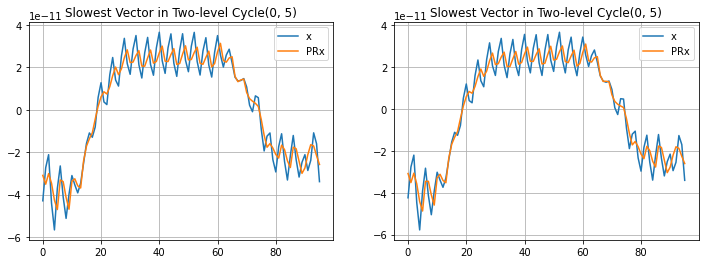

In [56]:
helmholtz.analysis.stats.run_r_vs_q(level, z, r, p, q, aggregate_size, num_components, 5, 0)

#### Two-level Relaxation Mini-Cycle

Restriction r
INFO     Iter   |r|        Factor   RER    Factor   |e|   
INFO     0      2.087e+01           2.468           8.455
INFO     1      3.200e+00  (0.153)  0.663  (0.269)  4.829
INFO     2      4.158e-01  (0.130)  0.258  (0.389)  1.614
INFO     3      1.274e-01  (0.306)  0.113  (0.438)  1.130
INFO     4      8.793e-02  (0.690)  0.097  (0.860)  0.907
INFO     5      7.026e-02  (0.799)  0.095  (0.979)  0.740
INFO     6      5.697e-02  (0.811)  0.094  (0.988)  0.607
INFO     7      4.662e-02  (0.818)  0.093  (0.996)  0.499
INFO     8      3.824e-02  (0.820)  0.093  (0.998)  0.410
INFO     9      3.140e-02  (0.821)  0.093  (0.999)  0.337
INFO     10     2.579e-02  (0.821)  0.093  (0.999)  0.277
INFO     11     2.118e-02  (0.821)  0.093  (0.999)  0.228
INFO     12     1.739e-02  (0.821)  0.093  (0.999)  0.187
INFO     13     1.427e-02  (0.821)  0.093  (0.998)  0.154
INFO     14     1.171e-02  (0.821)  0.093  (0.998)  0.127
INFO     15     9.604e-03  (0.820)  0.092  (0.998)  0.104

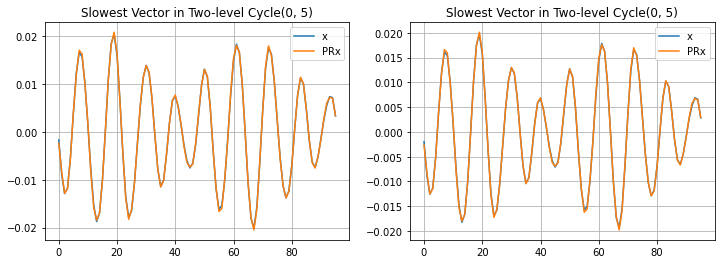

In [57]:
helmholtz.analysis.stats.run_r_vs_q(level, z, r, p, q, aggregate_size, num_components, 5, 5)

#### Level 1 Relaxation Shrinkage

#### $P^T A P$

INFO     Kaczmarz
INFO     Iter     |r|                         |x|         RER
INFO     0     3.708e-01                    4.467e-01    0.834
INFO     1     1.549e-01 (0.419) [0.419]    3.125e-01    0.500 (0.599)
INFO     2     9.702e-02 (0.624) [0.514]    2.588e-01    0.376 (0.755)
INFO     3     6.832e-02 (0.710) [0.570]    2.338e-01    0.296 (0.787)
INFO     4     5.473e-02 (0.804) [0.621]    2.158e-01    0.257 (0.871)
INFO     5     4.539e-02 (0.830) [0.658]    2.023e-01    0.227 (0.886)
INFO     6     3.893e-02 (0.857) [0.688]    1.915e-01    0.205 (0.906)
INFO     7     3.414e-02 (0.877) [0.712]    1.827e-01    0.189 (0.920)
INFO     8     3.048e-02 (0.892) [0.733]    1.753e-01    0.175 (0.930)
INFO     9     2.757e-02 (0.904) [0.750]    1.691e-01    0.164 (0.938)
INFO     10    2.520e-02 (0.913) [0.765]    1.637e-01    0.155 (0.944)
INFO     11    2.325e-02 (0.922) [0.778]    1.590e-01    0.147 (0.949)
INFO     12    2.161e-02 (0.929) [0.790]    1.548e-01    0.140 (0.954)
INFO 

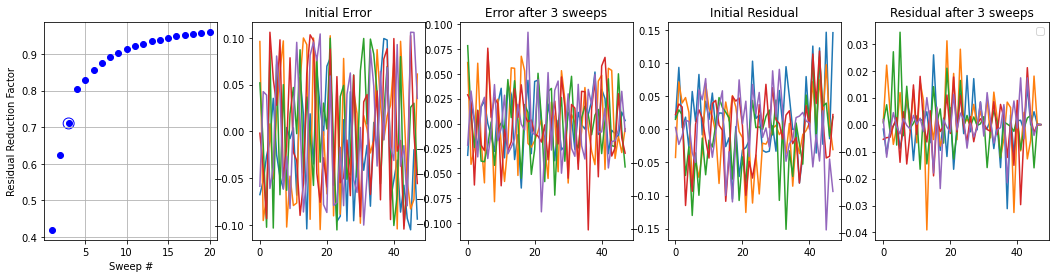

In [58]:
m0 = hm.repetitive.locality.create_two_level_hierarchy_from_matrix(
    level.a, level.location, r, p, p.T, aggregate_size, num_components)
m1 = m0.sub_hierarchy(1)
method_info = hm.solve.smoothing.check_relax_cycle_shrinkage(
    m1, num_levels=1, leeway_factor=leeway_factor, slow_conv_factor=0.98, max_sweeps=20)
num_sweeps = method_info["Kaczmarz"][1]

#### $Q A P$

INFO     Kaczmarz
INFO     Iter     |r|                         |x|         RER
INFO     0     2.763e-01                    4.459e-01    0.622
INFO     1     9.037e-02 (0.327) [0.327]    2.836e-01    0.322 (0.518)
INFO     2     5.603e-02 (0.621) [0.450]    2.301e-01    0.249 (0.773)
INFO     3     3.630e-02 (0.646) [0.508]    2.026e-01    0.184 (0.738)
INFO     4     2.792e-02 (0.769) [0.564]    1.852e-01    0.155 (0.846)
INFO     5     2.266e-02 (0.809) [0.606]    1.728e-01    0.135 (0.871)
INFO     6     1.909e-02 (0.840) [0.640]    1.635e-01    0.120 (0.891)
INFO     7     1.648e-02 (0.861) [0.668]    1.564e-01    0.109 (0.903)
INFO     8     1.448e-02 (0.876) [0.692]    1.506e-01    0.099 (0.912)
INFO     9     1.288e-02 (0.887) [0.711]    1.460e-01    0.091 (0.917)
INFO     10    1.157e-02 (0.895) [0.728]    1.421e-01    0.084 (0.921)
INFO     11    1.047e-02 (0.902) [0.742]    1.388e-01    0.078 (0.925)
INFO     12    9.546e-03 (0.909) [0.755]    1.361e-01    0.072 (0.928)
INFO 

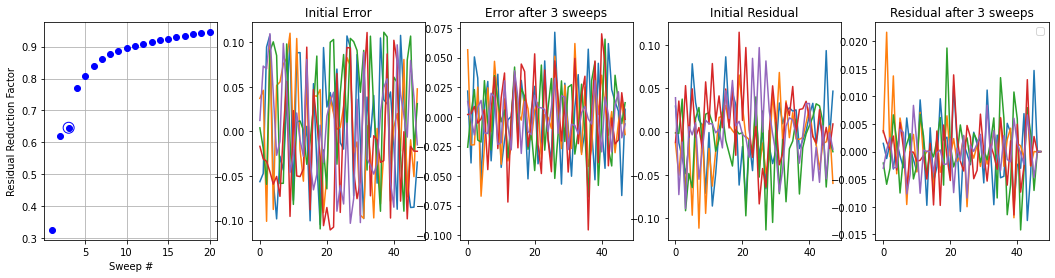

In [59]:
m0 = hm.repetitive.locality.create_two_level_hierarchy_from_matrix(
    level.a, level.location, r, p, q, aggregate_size, num_components)
m1 = m0.sub_hierarchy(1)
method_info = hm.solve.smoothing.check_relax_cycle_shrinkage(
    m1, num_levels=1, leeway_factor=leeway_factor, slow_conv_factor=0.98, max_sweeps=20)
num_sweeps = method_info["Kaczmarz"][1]

### Conclusions
* It is important to not exactly solve at the coarse level especially when null/near-null space components are present, in order to avoid inflating them due to round-off errors.
* $Q A P$ is as good as $R A P$ for different seeds.
* A two-level cycle (with many relaxations at the coarse level) does not reduce the RER more than relaxation. That's OK: again, many relaxations at the coarse level will affeect very smooth components and thus their aliasing.
* To see good shrinkage, use a relaxation mini-cycle (only several relaxations at the coarse level). Note that we only need one relaxation at the coarse level to get a good RER reduction (and indeed, Kaczmarz is a good smoother at level 1).

## Equation Interpretability
We (maybe) expect the coarse equations to be $U x_{i-1} + x_i + U^T x_{i+1}$ where $U$ is a rotation whose angle depends on $kh$.

In [60]:
# Normalized level 0 equations.
level.a.todense()[2, :5] / level.a.todense()[2,2]

matrix([[ 0.037, -0.599,  1.   , -0.599,  0.037]])

In [61]:
print("R")
display(pd.DataFrame(r[:2, :4].todense()))
print("Q")
display(pd.DataFrame(q[:2, :4].todense()))
print("P")
display(pd.DataFrame(ml[1]._p[6:10, 2:6].todense()))
print("RAP")
display(pd.DataFrame(r.dot(ml[0].a).dot(ml[1]._p)[4:6, 2:8].todense()))
print("QAP")
qap = q.dot(ml[0].a).dot(ml[1]._p)[4:6, 2:8].todense()
display(pd.DataFrame(qap))

R


,0,1,2,3
0,0.4377,0.5501,0.5527,0.4476
1,0.6723,0.2513,-0.2593,-0.6462


Q


,0,1,2,3
0,0.4390,0.5543,0.5552,0.4469
1,0.6619,0.2519,-0.2447,-0.6559


P


NameError: name 'ml' is not defined

In [ ]:
d = qap[:, 2:4]
u = qap[:, :2]
l, v = eig(d)
#l = np.diag(np.abs(np.real(lam))**(-0.5))
#v = v.dot(l)
U = v.T.dot(u).dot(v)

In [ ]:
# Off-diagonal U in U*x_{i-1} + x_i + U^T*x_{i+1} at level 1. x_i is a 2-species vector.
print("D", v.T.dot(d).dot(v))
print("U", U)

In [ ]:
# U = V^{-1}*D*V
D, V = eig(U)
print(V, D)

* The original diagonal block is already nearly diagonal.
* $U$ is nearly but not exactly anti-symmetric, as is the corresponding block before diagonalizing the central block.
What does it mean? Will it become symmetric in the limit of many coarsening levels?
* $U$ has real eigenvalues. In quantum mehcanics it's called "PT-symmetric" (space-time-reversible system). cf. https://math.stackexchange.com/questions/746223/besides-being-symmetric-when-will-a-matrix-have-only-real-eigenvalues, 
https://arxiv.org/pdf/1212.1861.pdf . This happens iff there exists a self-adjoint (symmetric positive definite here) $W$ such that $W U = U^* W$.

In [ ]:
# Example of an SPD matrix that commutes with U. Any w in the range where (b - c*w)^2 < (d-a)^2 w works. We take w = b/c, 
# which means W is nothing but a diagonal scaling of U...
#w = U[0, 1] / U[1, 0]
#w12 = (U[0, 1] - U[1, 0] * w) / (U[1, 1] - U[0, 0])
#W = np.array([[1, w12], [w12, w]])
W = np.diag(np.sign(np.real(l))).dot(np.array([[1, 0], [0, np.abs(U[0, 1] / U[1, 0])]]))
#W = np.array([[1, 0], [0, np.abs(U[0, 1] / U[1, 0])]])

In [ ]:
print("W", W, "W U", W.dot(U), "U^* T", U.T.dot(W), "diff", W.dot(U) - U.T.dot(W))

In [ ]:
# After the full transformation - diagonalizing the central block and symmetrizing U:
print("D")
print(W.dot(v.T).dot(d).dot(v))
print("U") 
print(W.dot(v.T).dot(u).dot(v))

So this is rather trivial - one can always make the central block symmetric. If it is positive definite, $U$ can be made anti-symmetric via diagonal scaling of the equations.

### Spectral Comparison

In [ ]:
# Minimum eigenvalue of A is machine 0.
lam = np.real(eig(level.a.todense())[0])
lam0 = lam[np.argsort(np.abs(lam))][:30]
print(lam0)
print("min", lam0[0])

In [ ]:
# Minimum eigenvalue of RAP is small but non-zero.
ac = r.dot(ml[0].a).dot(ml[1]._p)
lam = np.real(eig(ac.todense())[0])
lam1 = lam[np.argsort(np.abs(lam))][:30]
print(lam1)
print("min", lam1[0])

In [ ]:
# Minimum eigenvalue of QAP is the same.
ac = q.dot(ml[0].a).dot(ml[1]._p)
lam = np.real(eig(ac.todense())[0])
lam2 = lam[np.argsort(np.abs(lam))][:30]
print(lam2)
print("min", lam2[0])

In [ ]:
# High order operator eigenvalue of P^T*A*P i sthe same.
ac = ml[1]._p.T.dot(ml[0].a).dot(ml[1]._p)
lam = np.real(eig(ac.todense())[0])
lam3 = lam[np.argsort(np.abs(lam))][:30]
print(lam3)
print("min", lam2[0])

In [ ]:
fig, axs = plt.subplots(1, len(titles), figsize=(12, 4))

ax = axs[0]
ax.plot(lam0, "x", label="A")
ax.plot(lam1, "x", label="RAP")
ax.plot(lam2, "x", label="QAP")
ax.plot(lam3, "x", label="P^TAP")
ax.grid(True);
ax.legend();
ax.set_xlim([0, 30]);
ax.set_ylim([-0.6, 0.6]);
ax.set_title("Eigenvalue");
ax.set_ylabel("$i$")
ax.set_ylabel("$\lambda_i$")

ax = axs[1]
ax.scatter(lam0, np.abs(lam1 - lam0) / np.clip(np.abs(lam0), 1e-6, None), label="RAP")
ax.scatter(lam0, np.abs(lam2 - lam0) / np.clip(np.abs(lam0), 1e-6, None), label="QAP")
ax.scatter(lam0, np.abs(lam3 - lam0) / np.clip(np.abs(lam0), 1e-6, None), label="PTAP")
ax.grid(True);
ax.legend();
ax.set_xlabel("$\lambda$")
ax.set_ylabel("Relative Error")
ax.set_ylim([-0.01, 0.2]);
ax.set_title("Eigenvalue relative error");

Here we can clearly see that $QAP$ is a compromise between sparsity and accuracy: $P^T A P$ approximates many more eigenvalues accurately. It is unexpected that neither $P^T A P$ nor $R A P$ is exactly singular while $Q A P$ is (once again explaining while a direct coarse level solve is especially bad with $Q A P$).